# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf,col,mean,count,when,isnan,isnull
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import to_date,datediff,date_sub
from pyspark.sql.types import IntegerType,TimestampType,DateType

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# 1. Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
sparkify_data = "mini_sparkify_event_data.json"
df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

## 1.1 Check structure and number of records

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
# number of records
df.count()

286500

In [7]:
# the number of users in the dataset
df.select("userId").distinct().count()

226

## 1.2 Check `nan` and `null` value

In [8]:
# check nan
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [9]:
# check null
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



From above we can find that, there are 8346 items where personal information (`firstName`,`lastName`,`gender`,`location`,`useraAgent`)is not recorded, it's very possible that they belongs to the same group of users 

In [10]:
df.select('userId').where(isnull(col('registration'))).distinct().show()

+------+
|userId|
+------+
|      |
+------+



As expected, the `userId` is "", so they may be the visitors. Next we'll remove these records.

In [4]:
df = df.filter(col("userId")!="")
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



# 2. Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.


In [13]:
df.groupBy("auth").count().show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+



In [14]:
df.groupBy("level").count().show()

+-----+------+
|level| count|
+-----+------+
| free| 55721|
| paid|222433|
+-----+------+



In [15]:
df.select('page','status')\
  .groupBy('page','status')\
  .count().show()

+--------------------+------+------+
|                page|status| count|
+--------------------+------+------+
|           Downgrade|   200|  2055|
|       Save Settings|   307|   310|
|                Help|   200|  1454|
|Cancellation Conf...|   200|    52|
|            Settings|   200|  1514|
|          Add Friend|   307|  4277|
|             Upgrade|   200|   499|
|         Roll Advert|   200|  3933|
|      Submit Upgrade|   307|   159|
|               Error|   404|   252|
|                Home|   200| 10082|
|               About|   200|   495|
|     Add to Playlist|   200|  6526|
|              Logout|   307|  3226|
|         Thumbs Down|   307|  2546|
|              Cancel|   307|    52|
|           Thumbs Up|   307| 12551|
|            NextSong|   200|228108|
|    Submit Downgrade|   307|    63|
+--------------------+------+------+



In [16]:
# check if `Cancel` and `Cancellation Confirmation` refers to the same users
df.select('userId')\
.where(col("page")=="Cancel")\
.distinct()\
.alias("id_cancel")\
.union(
    df.select('userId')\
    .where(col("page")=="Cancellation Confirmation")\
    .alias("id_calcel_confirm")\
    .distinct()
).distinct().count()

52

From the result above, `Cancel` should be a prompt notification page, and those who successfully canceled the services may be directed to the `Cancellation Confirmation` page.


## 2.1 Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.


In [5]:
churned_users = df.select('userId').where(col("page")=="Cancellation Confirmation").distinct().collect()
churned_users = [x.userId for x in churned_users]
churned_user_fun = udf(lambda x: 1 if x in churned_users else 0,IntegerType())

df = df.withColumn("Churn",churned_user_fun("userId"))
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn=0)

In [18]:
len(churned_users)

52

## 2.2 Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### 1) Page uses

In [19]:
# page 
pages_existing = df.select('userId','page').where(col("Churn")==0).groupby('page').count().toPandas()
pages_churned  = df.select('userId','page').where(col("Churn")==1).groupby('page').count().toPandas()

pages_existing['proportion_eu']=pages_existing['count']/pages_existing['count'].sum()*100
pages_churned['proportion_cu'] =pages_churned['count'] /pages_churned['count'].sum()*100
pages = pages_churned.merge(pages_existing,on="page")

In [22]:
pages

,page,count_x,proportion_cu,count_y,proportion_eu
0,Submit Downgrade,9,0.020061,54,0.023147
1,Thumbs Down,496,1.105563,2050,0.878735
2,Home,1672,3.726819,8410,3.604955
3,Downgrade,337,0.751159,1718,0.736422
4,Roll Advert,967,2.155403,2966,1.271379
5,Logout,553,1.232614,2673,1.145784
6,Save Settings,58,0.129280,252,0.108020
7,About,56,0.124822,439,0.188178
8,Settings,270,0.601819,1244,0.533242
9,Add to Playlist,1038,2.313659,5488,2.352437


<function matplotlib.pyplot.show(close=None, block=None)>

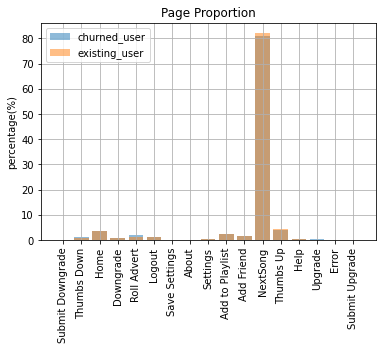

In [24]:
plt.bar(pages['page'],pages['proportion_cu'],label="churned_user",alpha=0.5)
plt.bar(pages['page'],pages['proportion_eu'],label="existing_user",alpha=0.5)
plt.title("Page Proportion")
plt.ylabel("percentage(%)")
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show

We can see that `NextSong` is the most frequent choice for both kinds of users. Since its proportion it too high compared with others, we drop it and see if there's any other significant difference between the two group. 

<function matplotlib.pyplot.show(close=None, block=None)>

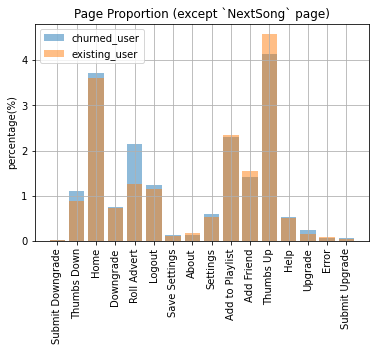

In [25]:
pages_small = pages[pages['page']!="NextSong" ]
plt.bar(pages_small['page'],pages_small['proportion_cu'],label="churned_user",alpha=0.5)
plt.bar(pages_small['page'],pages_small['proportion_eu'],label="existing_user",alpha=0.5)
plt.title("Page Proportion (except `NextSong` page)")
plt.ylabel("percentage(%)")
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show

Clearly, churned users seem to have more negative actions(`Thumbs Down`,`Roll Advert`), while existing users have more positive actions(`Add Friend`,`Thumb Up`)

### 2) Usage Duration



In [23]:
len_existing = df.select('userId','length').where(col("Churn")==0).groupby('userId').agg(mean("length")).toPandas()
len_churned  = df.select('userId','length').where(col("Churn")==1).groupby('userId').agg(mean("length")).toPandas()

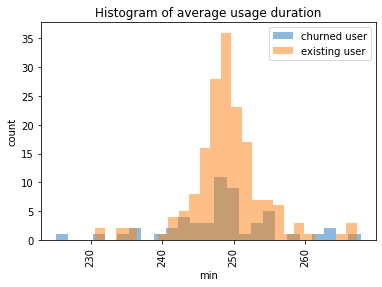

In [24]:
plt.hist(len_churned['avg(length)'],bins=25,label="churned user",alpha=0.5)
plt.hist(len_existing['avg(length)'],bins=25,label="existing user",alpha=0.5)
plt.xticks(rotation=90)
plt.xlabel("min")
plt.ylabel("count")
plt.title("Histogram of average usage duration")
plt.legend()
plt.show()

In [25]:
cu_len_mean,cu_len_mid = np.mean(len_churned['avg(length)']), np.median(len_churned['avg(length)'])
eu_len_mean,eu_len_mid = np.mean(len_existing['avg(length)']), np.median(len_existing['avg(length)'])

print("Usage duration (min)")
print(f"[Existing users] mean:{eu_len_mean}, median:{eu_len_mid} ") 
print(f"[Churned  users] mean:{cu_len_mean}, median:{cu_len_mid} ")

Usage duration (min)
[Existing users] mean:249.1412535406481, median:249.16812640511915 
[Churned  users] mean:248.30786496247958, median:248.28066978737792 


Churned users spend slightly less time than existing users.

# 3. Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a **script** to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## 3.1 Transform timestamp to datetime

In [7]:
ts_to_date = udf(lambda x: datetime.fromtimestamp(x/1000.0), DateType())
df = df.withColumn('registration_date',ts_to_date(col("registration")))
df = df.withColumn('event_date',ts_to_date(col("ts")))
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn=0, registration_date=datetime.date(2018, 9, 29), event_date=datetime.date(2018, 10, 1))

##  3.2 Features needed for modeling

1. User's personal information:
   - gender
   
   
2. User account status:
   - Tenure (number of days since registration)
   - Number of active days
   - Level: `1` for `paid`, `0` for `free`
   - Change of service
     - Upgrade(page:`Submit Upgrade`): `1` for yes, `0` for no
     - Downgrade(page:`Submit Downgrade`): `1` for yes, `0` for no
       
       
3. Usage information:
   - Average length of use during the current window period
   - Change in average usage duration  `length`
   - Change in average items number `itemInSession`
   - Change in the number of pages visited 
     - negative feelings (`Thumbs Down`)
     - positive feelings (`Thumbs Up`)
     - errors (`Error`)
     - socialization (`Add Friend`)
     - advert (`Roll Advert`)
     - add to play list (`Add to Playlist`)

> The "change" above is compared to the previous window period 



--- 

1. User's personal information


In [6]:
# gender : `1` for male, `0` for female
gender_fun = udf(lambda x:1 if x=="M" else 0, IntegerType()) 
user_mat   = df.withColumn("gender_flag",gender_fun(col("gender")))\
                .select("userId","gender_flag")\
                .distinct()

----
2. User account status

In [8]:
# prework : registration date
regist = df.select("userId","registration_date").distinct()
user_mat = user_mat.join(regist,on=["userId"],how="left")


# prework : find most recent event date
most_resent = df.select("userId","event_date")\
                .groupBy("userId")\
                .agg(Fmax("event_date"))\
                .withColumnRenamed("max(event_date)","most_resent")

user_mat = user_mat.join(most_resent,on=["userId"],how="left")

In [9]:
# (1) tenure
user_mat = user_mat.withColumn('tenure',
                               datediff(
                                   col("most_resent"),
                                   col("registration_date")
                               ))

In [10]:
# (2) active_days
active = df.select("userId","event_date")\
            .groupBy("userId")\
            .count()\
            .withColumnRenamed("count","active_days")
user_mat = user_mat.join(active,on=["userId"],how="left")

In [11]:
# (3) level : `1` for `paid`, `0` for `free`
level_fun = udf(lambda x : 1 if x=="paid" else 0, IntegerType())
level = df.withColumn("level",level_fun(col("level")))\
            .select("userId","level")\
            .distinct()
user_mat = user_mat.join(level,on=["userId"],how="left")

In [12]:
# (4) change of service
upgrated_fun   = udf(lambda x : 1 if x=="Submit Upgrade" else 0, IntegerType())
downgrated_fun = udf(lambda x : 1 if x=="Submit Downgrade" else 0, IntegerType())

df = df.withColumn("upgraded",upgrated_fun(col("page")))
df = df.withColumn("downgraded",downgrated_fun(col("page")))

service_change = df.select("userId","upgraded","downgraded").distinct()
user_mat = user_mat.join(service_change,on=["userId"],how="left")

In [13]:
user_mat.head()

Row(userId='73', gender_flag=0, registration_date=datetime.date(2018, 9, 5), most_resent=datetime.date(2018, 10, 24), tenure=49, active_days=457, level=1, upgraded=1, downgraded=0)

---
3. Userage information  

In [19]:
def get_date_point(df,col_name:str,period=14):
    """
    Get the date point of a given period beform the most recent date
    
    INPUT
    @df       : a pyspark dataframe that contains all the activities and their event_date
    @col_name : str, the event to be chosen
    @period   : int, period(day) before the most resent event
    
    OUTPUT
    @date_point: a dataframe with `userId`, the column given, the most resent date,
                 date point of 1 period and 2 periods before the most resent date
    """
    date_point = df.select("userId",col_name,"event_date")\
                    .join(most_resent,on="userId",how="left")
    date_point = date_point.withColumn("1period_ago",date_sub("most_resent",period))
    date_point = date_point.withColumn("2period_ago",date_sub("most_resent",period*2))
    return date_point

In [18]:
def get_records_during_periods(date_point,col_name:str):
    """
    Get 2 dataframe of records which is during "resent ~ 1period_ago" and  "1period_ago ~ 2period_ago"
    
    INPUT:
    @date_point : a dataframe generated from the function `get_date_point`
    @col_name   : str, the column of activity, which should be in date_point (the same as used in `get_date_point`)
    
    PUTOUT:
    @records_recent : records during most_resent and 1period_ago 
    @records_last   : records during 1period_ago and 2period_ago 
    """
    records_recent = date_point.select("userId",col_name)\
                            .filter((col("event_date")<col("most_resent")) & (col("event_date")>col("1period_ago")))\
                            .dropna()

    records_last   = date_point.select("userId",col_name)\
                            .filter((col("event_date")<col("1period_ago")) & (col("event_date")>col("2period_ago")))\
                            .dropna()
    return records_recent,records_last


In [17]:
def get_record_avg(df_records,col_name:str,avg_col_name:str):
    """
    Calculate the average value of records (for numerical records)
    
    INPUT:
    @df_records   : contains 2 column - `userId` and the column with "col_name" 
                    Generally it's the output of "get_records_during_periods" function
    @col_name     : str, the name of column where the average will be calculated
    @avg_col_name : str, the name of average result
    
    OUTPUT:
    @ a dataframe grouped by "userId", with the average result value
    """
    df_records = df_records.groupBy("userId")\
                        .agg(mean(col_name))\
                        .withColumnRenamed("avg("+col_name+")",avg_col_name)\
                        .drop(col_name)
    return df_records

In [16]:
def get_diff_between_period(df_resent, df_last, col_name1:str, col_name2:str, diff_col_name:str):
    """
    Calculate the difference on two records dataframe
    
    INPUT
    @df_resent     : dataframe of resent records (already grouped by `userId`)
    @df_last       : dataframe of last records   (already grouped by `userId`)
    @col_name1     : a col in df_resent, where there stores the records value
    @col_name2     : a col in df_last, where there stores the records value
    @diff_col_name : name of the column of difference result
    """
    duration_change =  df_resent.join(df_last,on="userId")\
                    .withColumn(diff_col_name, 
                                (( 
                                    df_resent.colRegex(col_name1)-
                                    df_last.colRegex(col_name2)
                                )) 
                               )\
                    .drop(col_name1,col_name2)
    return duration_change

In [14]:
def pivot_and_count(df_records,col_name:str):
    """
    Count the number of frequency of each category in col (for categorical records)
    
    INPUT:
    @df_records : dataframe of records
    @col_name   : name of column where the value is  categorical
    
    OUTPUT:
    @pivoted : a data frame where  
               - the columns are the categories in the given column,
               - each row starts with the "userId",
               - the value in dataframe is the count number per category per user
    """
    pivoted = df_records.select("userId",col_name)\
                        .groupBy("userId")\
                        .pivot(col_name)\
                        .count()\
                        .fillna(0)
    return pivoted

In [20]:
# (1) Change in usage duration

col_name = "length"
avg_col_name1 = "avg_duration_recent"
avg_col_name2 = "avg_duration_last"
diff_col_name = "delta_avg_duration"

# get date point
duration_date = get_date_point(df,col_name)

# users duration records in specific time period
duration_resent,duration_last = get_records_during_periods(duration_date,col_name)

# calculate average usage during period
duration_resent = get_record_avg(duration_resent,col_name,avg_col_name1)
duration_last   = get_record_avg(duration_last  ,col_name,avg_col_name2)

# calculate average duration change
duration_change =  get_diff_between_period(duration_resent,duration_last,
                                          avg_col_name1,avg_col_name2,
                                          diff_col_name)
# combine result
user_mat = user_mat.join(duration_resent,on="userId",how="left")
user_mat = user_mat.join(duration_change,on="userId",how="left")

In [21]:
duration_change.show()

+------+--------------------+
|userId|  delta_avg_duration|
+------+--------------------+
|100010|   -10.2593935784314|
|200002|   7.379703260869491|
|    51| -0.8669089466685875|
|   124|   5.010701413485322|
|    54|  0.8294058416134646|
|    15|  3.1510405870156717|
|   155|   4.020502904005156|
|   132|  -8.041101177288908|
|   101|   2.368436019985751|
|    11|   10.12948090517233|
|   138|   5.696534609535348|
|300017| -0.7926954844743364|
|    29|  -6.773089492002896|
|    69|   -1.36281672571522|
|    42|-0.09412463738615884|
|    87|  -5.435071872123842|
|    73| -11.125306407015387|
|    64| -28.699245714285723|
|     3|   7.086307077921958|
|   113| -0.8227775342437269|
+------+--------------------+
only showing top 20 rows



In [22]:
# (2) Change in average items number 

col_name = "itemInSession"
avg_col_name1 = "avg_nb_item_recent"
avg_col_name2 = "avg_nb_item_last"
diff_col_name = "delta_avg_nb_item"

# get date point
nb_item_date = get_date_point(df,col_name)

# users nb_item records in specific time period
nb_item_resent,nb_item_last = get_records_during_periods(nb_item_date,col_name)

# calculate average usage during period
nb_item_resent = get_record_avg(nb_item_resent,col_name,avg_col_name1) 
nb_item_last   = get_record_avg(nb_item_last  ,col_name,avg_col_name2)

# calculate average nb_item change
nb_item_change = get_diff_between_period(nb_item_resent,nb_item_last,
                                        avg_col_name1,avg_col_name2,
                                        diff_col_name)
# combine result
user_mat = user_mat.join(nb_item_change,on="userId",how="left")

In [121]:
nb_item_change.show()

+------+-------------------+
|userId|  delta_avg_nb_item|
+------+-------------------+
|100010| 18.611111111111114|
|200002| 15.984732824427482|
|    51|-126.80792057444313|
|   124| -97.46540125361959|
|    54| 52.412565986193655|
|    15| -91.23566506706042|
|   155|  3.395527293406886|
|   132| -76.57311247980736|
|   101| 251.42880085242737|
|    11|  53.70834229528346|
|   138| 242.61564432664397|
|300017|-19.874310413387924|
|    29|  99.93030070118664|
|    69| 116.68567484336836|
|    42|-13.629029357513602|
|    87|  10.70537491705375|
|    73| -7.382640770852149|
|    64|              13.25|
|     3|  45.75136612021858|
|   113| 16.102063177526524|
+------+-------------------+
only showing top 20 rows



In [23]:
# (3) Change in the number of pages visited 

col_name = "page"

# determine the time point
page_date = get_date_point(df,col_name)

# users page records in specific time period
pages_recent, pages_last = get_records_during_periods(page_date,col_name)

# users page count in a specific time period
pages_count_recent = pivot_and_count(pages_recent,col_name)
pages_count_last   = pivot_and_count(pages_last,col_name)

# columns to keep 
keep_cols = ["userId", "Thumbs Up", "Thumbs Down", "Error", "Roll Advert", "Add Friend", "Add to Playlist"]
p1 = pages_count_recent.select(keep_cols)
p2 = pages_count_last.select(keep_cols)

# calculate difference between 2 periods
keep_cols.remove("userId")
for c in keep_cols:
    p1 = p1.join(p2.select("userId",c),on="userId")\
            .withColumn("delta "+c, (( p1.colRegex(c)-p2.colRegex(c) )) )\
            .drop(c)
user_mat = user_mat.join(pages_count_recent,on="userId",how="left")
user_mat = user_mat.join(p1,on="userId",how="left")

In [125]:
p1.show()

+------+---------------+-----------------+-----------+-----------------+----------------+---------------------+
|userId|delta Thumbs Up|delta Thumbs Down|delta Error|delta Roll Advert|delta Add Friend|delta Add to Playlist|
+------+---------------+-----------------+-----------+-----------------+----------------+---------------------+
|100010|              1|               -1|          0|               10|              -1|                    2|
|200002|              1|               -2|          0|                0|               0|                    1|
|   124|            -42|              -12|          1|                0|             -29|                  -31|
|    51|             46|               10|          1|                0|               6|                   13|
|    54|             37|                4|          0|              -41|               2|                   16|
|    15|              7|                2|          0|               -1|               7|               

## 3.3 Save feature dataframe

In [24]:
# label
churn_flag = df.select("userId","Churn").distinct()

user_mat = user_mat.join(churn_flag,on="userId",how="left")

In [29]:
user_mat.head()

Row(userId='73', gender_flag=0, registration_date=datetime.date(2018, 9, 5), most_resent=datetime.date(2018, 10, 24), tenure=49, active_days=457, level=1, upgraded=1, downgraded=0, avg_duration_recent=245.74858868913844, delta_avg_duration=-11.125306407015387, delta_avg_nb_item=-7.382640770852149, delta Thumbs Up=10, delta Thumbs Down=3, delta Error=1, delta Roll Advert=-1, delta Add Friend=5, delta Add to Playlist=9, About=1, Add Friend=8, Add to Playlist=10, Downgrade=0, Error=1, Help=2, Home=10, Logout=5, NextSong=267, Roll Advert=0, Save Settings=1, Settings=2, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=5, Thumbs Up=12, Upgrade=0, Churn=1)

In [30]:
# save data 
user_mat.write.json("user_mat.json") 

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.